In [1]:
# libraries 

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\Wind Turbine\\exercises\\propeller')


In [2]:
# constants

P_rated = 22*10**3
omega = 2600*2*np.pi/60
R = 0.69
rho = 1.225
theta_p = 0
B = 2
eps=10**-4
max_iteration=1000
beta = 0.1


shape_data = pd.read_excel('shape.xlsx')
r_array = shape_data['r'].to_list()
twist_array = shape_data['twist'].to_list()
c_array = shape_data['chord'].to_list()


In [3]:
# functions


def bem_algorithm(V,omega,r, theta_p, twist, B, eps, max_iteration, beta, c):
    a_new, a_prime_new = 0, 0
    k, count = 0, 0

    while k==0:
        count+=1  

        a_old, a_prime_old = a_new, a_prime_new

        phi = np.arctan(((1+a_old)*V)/((1-a_prime_old)*omega*r))

        theta = theta_p + twist

        alpha = theta - phi 

        Cl = 0.1*np.degrees(alpha) + 0.4

        Cd = 0.008

        Cn = Cl * np.cos(phi) - Cd * np.sin(phi)

        Ct = Cl * np.sin(phi) + Cd * np.cos(phi)

        F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r * np.sin(abs(phi)))))

        sigma= c*B/(2*np.pi*r)

        a_star = ((1+a_old)*sigma*Cn)/(4*F*((np.sin(phi))**2))
        a_new = beta*a_star + (1-beta)*a_old
        
        a_prime_star = (1 - a_prime_old) * ((sigma * Ct) / (4 * F * (np.sin(phi) * np.cos(phi))))
        a_prime_new = beta*a_prime_star + (1-beta)*a_prime_old
        
        if abs(a_new - a_old) < eps and abs(a_prime_new - a_prime_old) < eps:
            k=1
        if count>max_iteration :
            k=1
            print('not converged')

    return a_new,a_prime_new,Cn,Ct


def get_local_loads(V, r_array, twist_array,c_array):

    list_loads = []

    for i in range(len(r_array)-1):
        r = r_array[i]
        twist = np.radians(twist_array[i])
        c = c_array[i]

        a,a_prime,Cn,Ct = bem_algorithm(V,omega,r, theta_p, twist, B, eps, max_iteration, beta, c)
        
        Vrel = np.sqrt(((1+a)*V)**2 + ((1-a_prime)*omega*r)**2)

        pn = 0.5*rho*Vrel**2*c*Cn

        pt = 0.5*rho*Vrel**2*c*Ct

        deltaP=omega*B*pt*r
        
        deltaT=B*pn

        list_loads.append([r,pn,pt,deltaT,deltaP])

    list_loads.append([r_array[-1],0,0,0,0])
    return(np.array(list_loads))


def get_global_loads():
    list_loads = get_local_loads(V, r_array, twist_array,c_array)

    P=integrate.simps(y=list_loads[:,4],x=list_loads[:,0])
    T=integrate.simps(y=list_loads[:,3],x=list_loads[:,0])   
    eta = T*V / P

    return P, T, eta


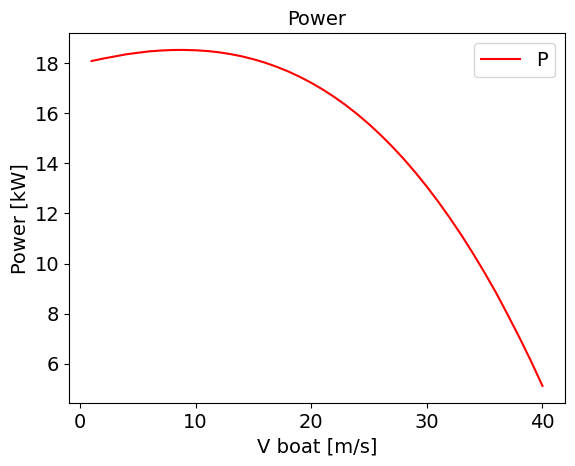

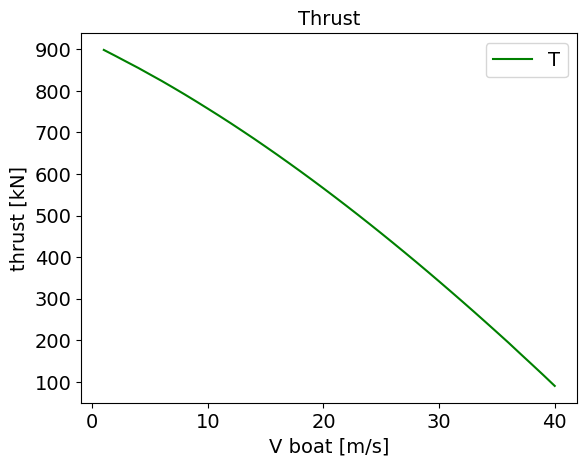

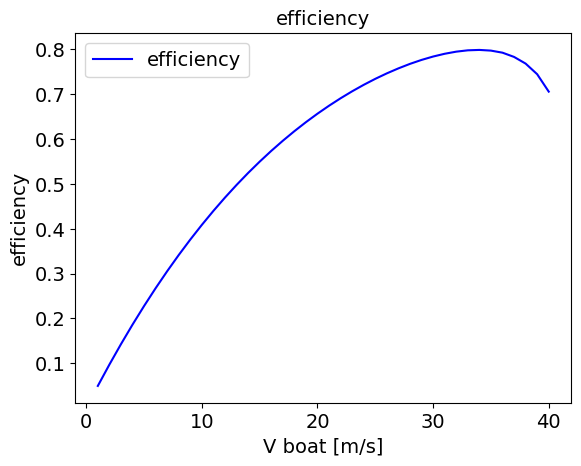

In [6]:
# QUESTION 1

Vb_array =np.linspace(1,40, num=40)
#Vb_array =np.linspace(1,2, num=2)
P_array = []
T_array = []
eta_array = []

for V in Vb_array:
    P, T, eta = get_global_loads()
    P_array.append(P/1000)
    T_array.append(T)
    eta_array.append(eta)

plt.figure(1)    
plt.plot(Vb_array, P_array, color='r', label = 'P')

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.xlabel('V boat [m/s]')
plt.ylabel('Power [kW]')
plt.legend(loc='lower right')
plt.title('Power')
plt.legend()


plt.figure(2)    
plt.plot(Vb_array, T_array, color='g', label = 'T')

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.xlabel('V boat [m/s]')
plt.ylabel('thrust [kN]')
plt.legend(loc='lower right')
plt.title('Thrust')
plt.legend()


plt.figure(3)    
plt.plot(Vb_array, eta_array, color='b', label = 'efficiency')

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.xlabel('V boat [m/s]')
plt.ylabel('efficiency')
plt.legend(loc='lower right')
plt.title('efficiency')
plt.legend()
plt.show()


intersection at V_boat = 16.19 m/s


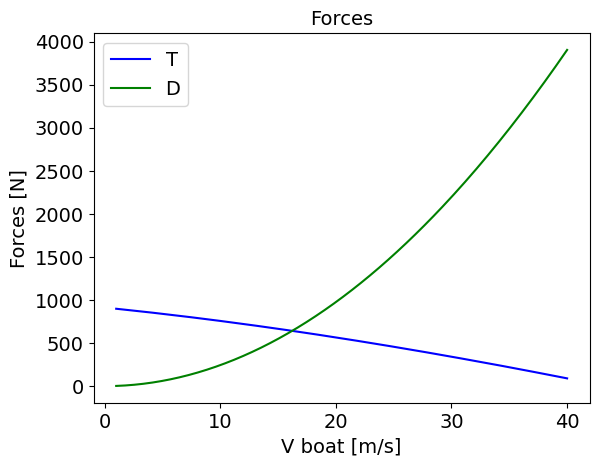

In [5]:
# QUESTION 3

Vb_array =np.linspace(1,40, num=200)
P_array = []
T_array = []
eta_array = []
D_array = []

for V in Vb_array:
    P, T, eta = get_global_loads()
    P_array.append(P/1000)
    T_array.append(T)
    eta_array.append(eta)
    D = 2.44*V**2
    D_array.append(D)

point = 0
intersection = 0
for i in range(len(Vb_array)):
    if point == 0:
        if T_array[i] < D_array[i]:
            point = i
            intersection = (Vb_array[i-1] + Vb_array[i])/2

print(f"intersection at V_boat = {intersection:.2f} m/s")


plt.figure(1)    
plt.plot(Vb_array, T_array, color='b', label = 'T')
plt.plot(Vb_array, D_array, color='g', label = 'D')

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.xlabel('V boat [m/s]')
plt.ylabel('Forces [N]')
plt.legend(loc='lower right')
plt.title('Forces')
plt.legend()
plt.show()
